<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Определение-функций" data-toc-modified-id="Определение-функций-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Определение функций</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-и-выбор-модели" data-toc-modified-id="Обучение-и-выбор-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и выбор модели</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Модель-на-основе-случайного-леса" data-toc-modified-id="Модель-на-основе-случайного-леса-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель на основе случайного леса</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from tqdm import notebook
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 5

## Подготовка

In [2]:
# Загрузим данные из файлов
try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Рассмотрим первые строки и общие сведения
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Каждый объект в наборе данных — это информация о количестве заказов. Столбцы содержат следующую информацию (признаки):
- `datetime` — дата и время (каждые 10 мин),
- `num_orders` — количество заказов. **Целевой признак.**  
Пропусков в данных нет.

In [5]:
# Преобразуем тип данных в столбце с датой и временем
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# Проверим столбец с датой и временем на упорядоченность
df['datetime'].is_monotonic_increasing

True

In [7]:
# Cтолбец с датой и временем используем для индесации данных
df.set_index(['datetime'], inplace=True)

In [8]:
# Определим суммарное количество заказов за час. В расчёте не будет включена граница слева,
# будет включена граница справа, т.е. для первого часа значение в 00:00:00 не включается в расчёт суммы за час, а
# значение в 00:01:00 включается в расчёт суммы за час. Сумма для первого часа будет под индексом "дата 01:00:00",
# второго часа - "дата 02:00:00" и т.д.
df = df.resample('1H', closed='right', label='right').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4417 entries, 2018-03-01 00:00:00 to 2018-09-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4417 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
# Выделим целевой признак
y = ['num_orders']

## Определение функций

In [10]:
# Определим функцию, которая возвращает название месяца по его номеру
def month_from_number (month_number):
    dictionary = {1:'January', 2:'February', 3:'March',
     4:'April', 5:'May', 6:'June',
     7:'July', 8:'August', 9:'September',
     10:'October', 11:'November', 12:'December'}
    return dictionary[month_number]

In [11]:
# Определим функцию, которая возвращает номер месяца по его названию
def dow_from_number (dow_number):
    dictionary = {0:'Monday', 1:'Tuesday', 2:'Wednesday',
     3:'Thursday', 4:'Friday', 5:'Saturday',
     6:'Sunday'}
    return dictionary[dow_number]

In [12]:
# Определим функцию для добавления временнЫх признаков
def add_features(data, max_lag, rm_size):
    out = data.copy()
    for lag in range(1, max_lag + 1):
        out[f'lag_{lag}'] = out['num_orders'].shift(lag)
    out['rolling_mean'] = out['num_orders'].shift().rolling(rm_size).mean()
    return out

## Анализ

In [13]:
# Рассмотрим основные статистики и гистограмму
df.describe()

,num_orders
count,4417.000000
mean,84.403668
std,44.988780
min,0.000000
25%,54.000000
50%,79.000000
75%,108.000000
max,422.000000


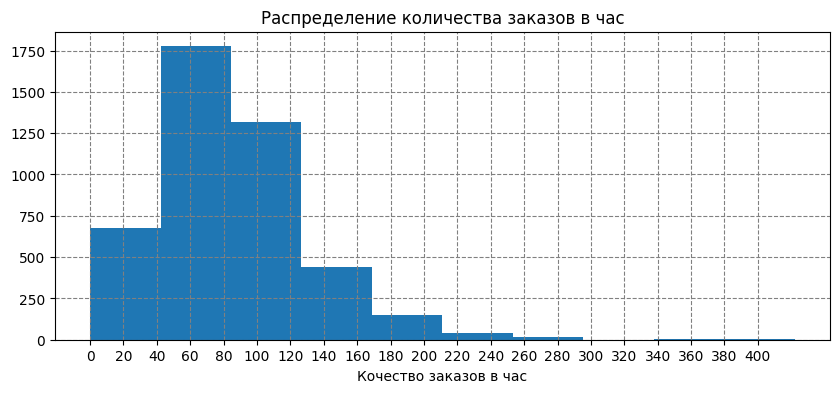

In [14]:
# Посмотрим распределение
plt.figure(figsize=(10, 4))
plt.title('Распределение количества заказов в час')
plt.grid(which='both', linestyle='--', color='grey')
plt.xticks(range(0,401,20))
plt.hist(df)
plt.xlabel('Кочество заказов в час')
plt.show()

Видим, что чаще всего бывает от 50 до 80 заказов в час. При этом бывают и часы без заказов, а также пиковые часы с количеством заказов более 200.

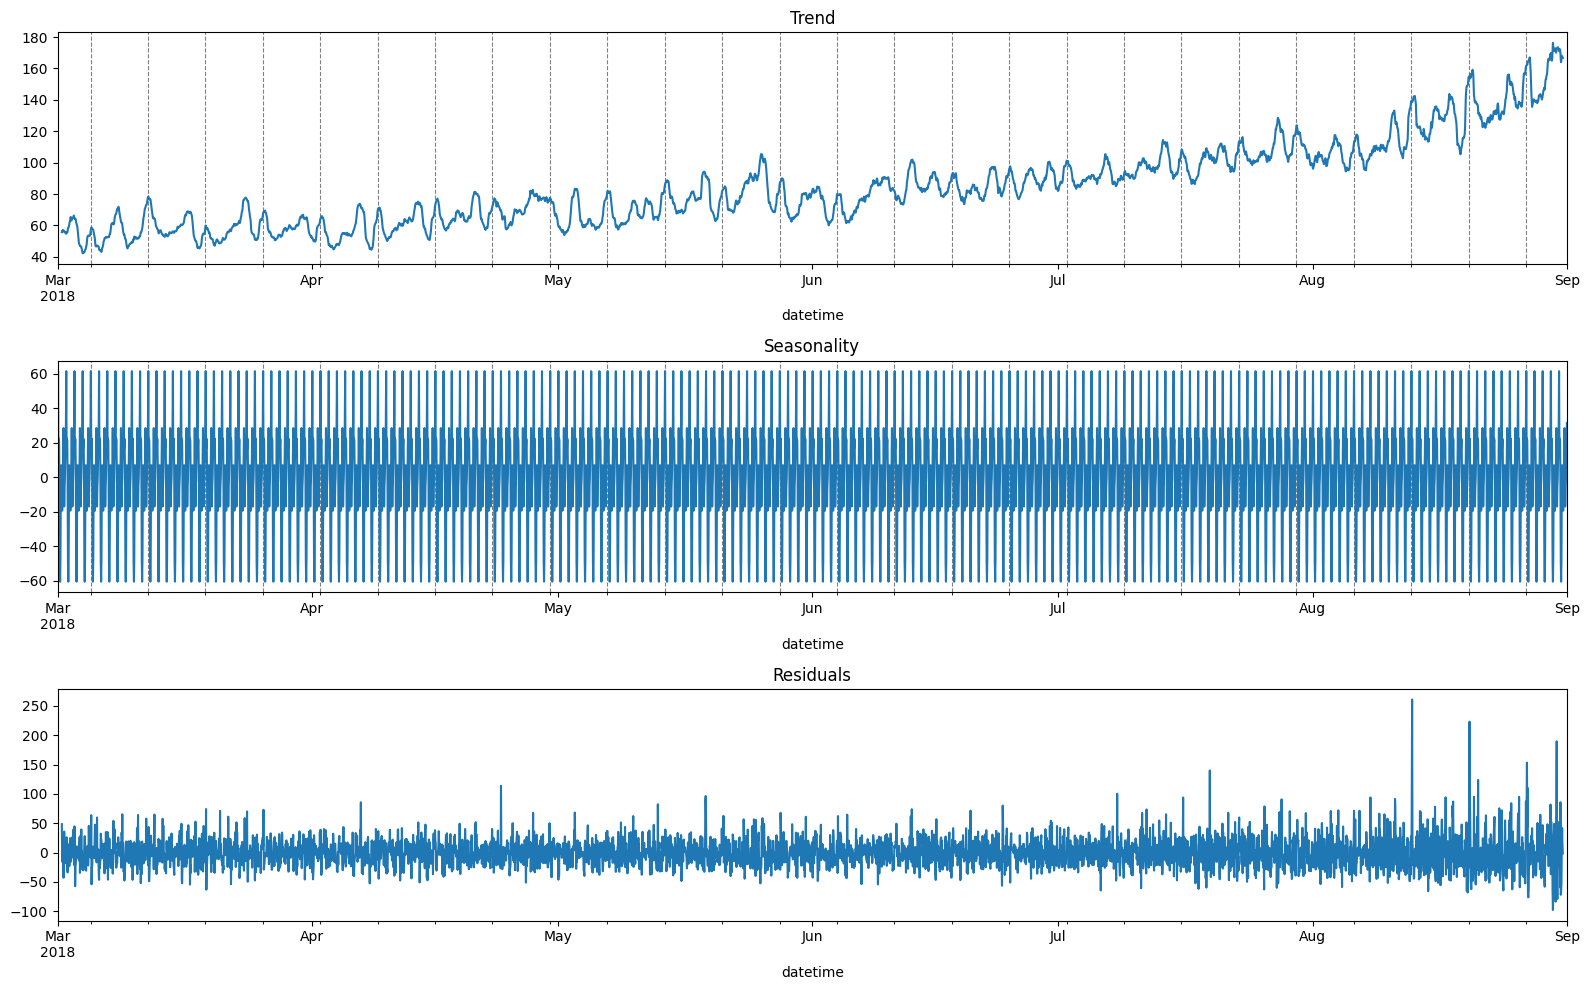

In [15]:
# Проанализируем колчество заказов на предмет тенденций и периодических изменений
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
# Плавные изменения (тренды)
plt.title('Trend')
plt.grid(which='both', linestyle='--', color='grey')
decomposed.trend.plot(ax=plt.gca())
plt.subplot(312)
# Периодические изменения
plt.title('Seasonality')
plt.grid(which='both', linestyle='--', color='grey')
decomposed.seasonal.plot(ax=plt.gca())
plt.subplot(313)
# Остатки
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим, что за период с марта по сентябрь 2018 г наблюдается тенденция по возрастанию количества заказов в час. Рассмотрим периодические изменения с другим масштабом времени (за период с 5 по 25 марта 2018 г, чтоб в рассматриваемом диапазоне было три полные недели). 

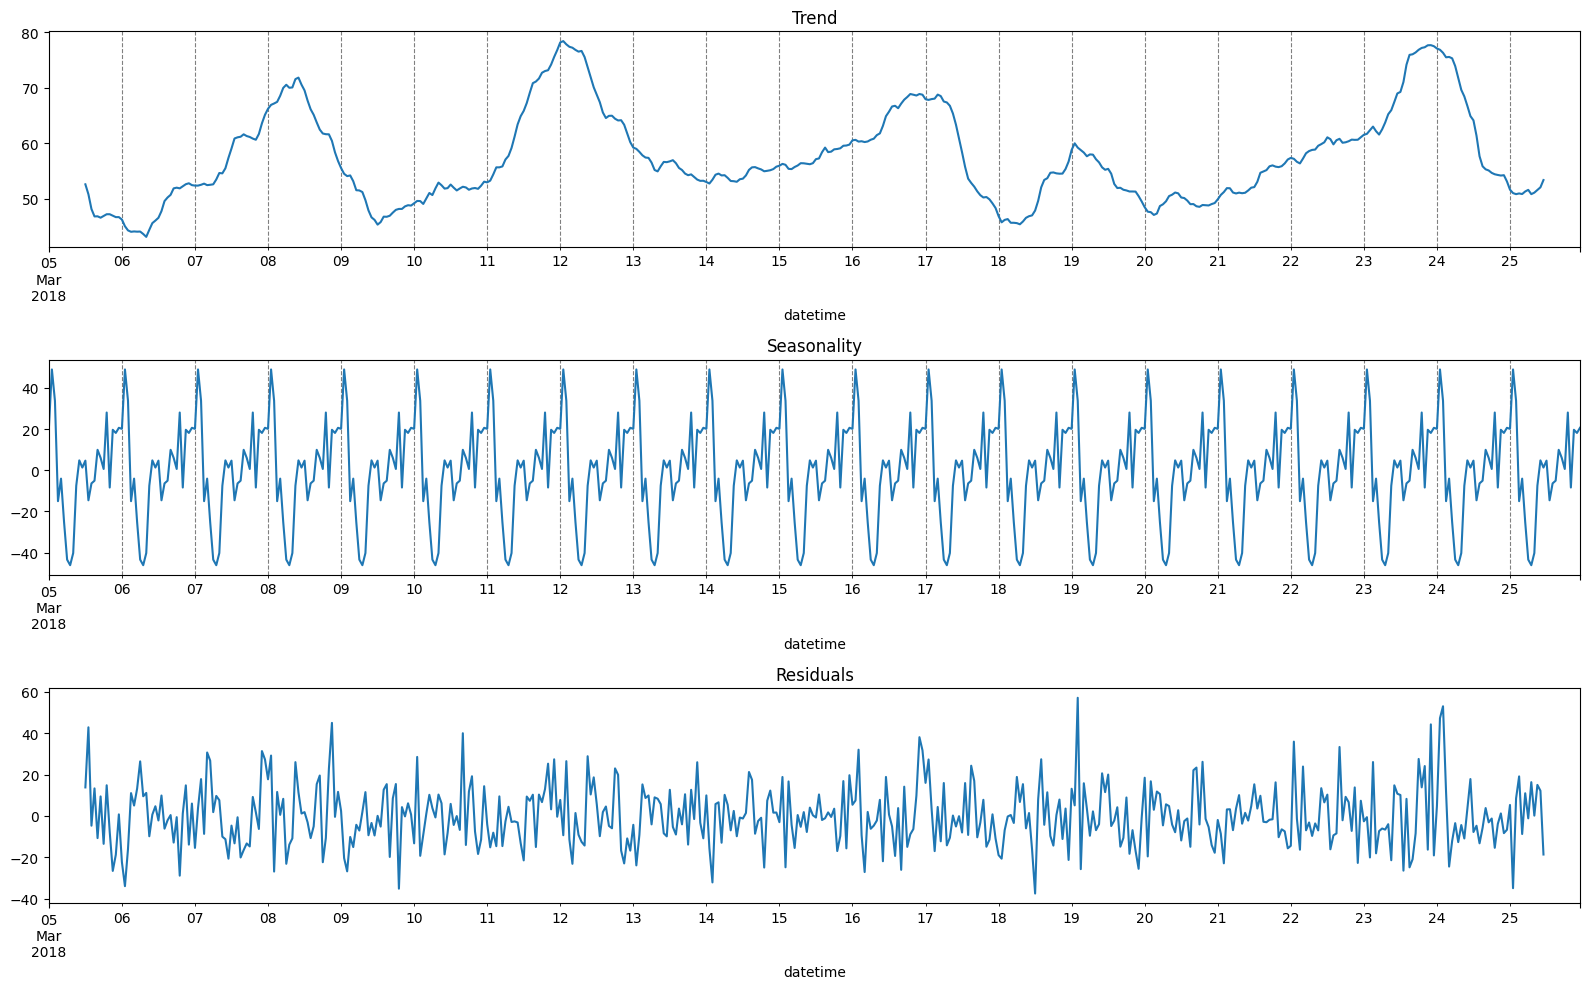

In [16]:
# Проанализируем колчество заказов на предмет тенденций и периодических изменений
decomposed = seasonal_decompose(df['2018-03-05':'2018-03-25'])

plt.figure(figsize=(16, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
# Плавные изменения (тренды)
plt.title('Trend')
plt.grid(which='both', linestyle='--', color='grey')
decomposed.trend.plot(ax=plt.gca())
plt.subplot(312)
# Периодические изменения
plt.title('Seasonality')
plt.grid(which='both', linestyle='--', color='grey')
decomposed.seasonal.plot(ax=plt.gca())
plt.subplot(313)
# Остатки
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графиков видно, что количество заказов в час возрастает в вечерние часы и уменьшается к утру, возрастает в пятницу, понедельник, уменьшается в будние дни со вторника по четверг и в воскресенье. Проанализируем подробнее, как связаны календарные признаки и целевой признак.

In [17]:
# Создадим колонки с календарными признаками
df['month'] = df.index.month
df['day'] = df.index.day
df['dow'] = df.index.dayofweek
df['hour'] = df.index.hour

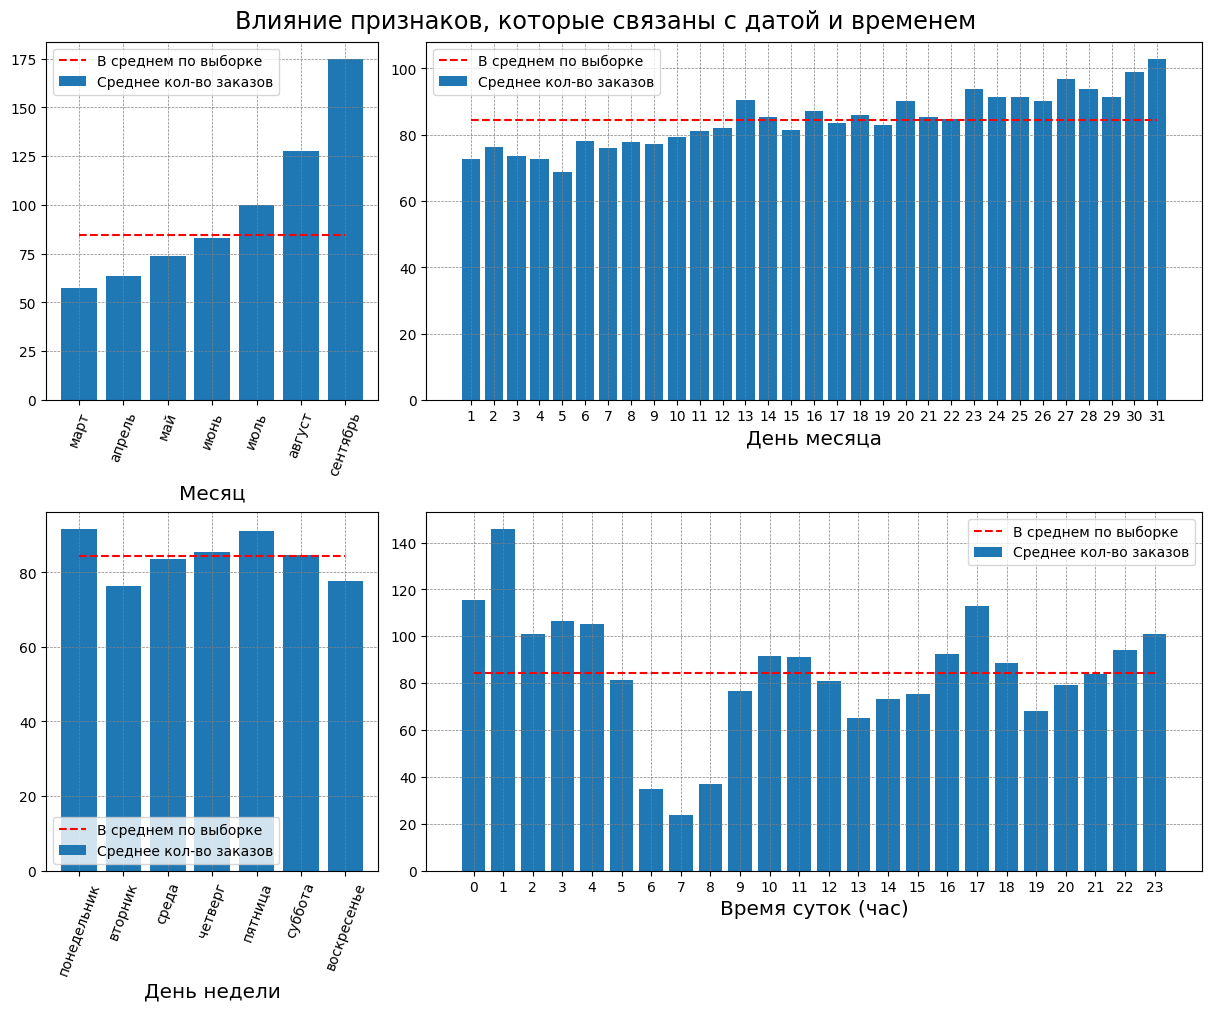

In [18]:
# Посмотрим, как связано количество заказов в час и такие факторы, как время суток, день недели, месяц
fig, ax = plt.subplots(ncols=2, nrows=2,
                       figsize=(12, 10),
                       sharex=False,
                       gridspec_kw={'width_ratios': (.3, .7)},
                       constrained_layout=True)
fig.suptitle('Влияние признаков, которые связаны с датой и временем',
             fontsize='xx-large')
month_data = df.groupby(by='month').agg(mean=('num_orders','mean')).sort_values(by='month')
day_data = df.groupby(by='day').agg(mean=('num_orders','mean')).sort_values(by='day')
dow_data = df.groupby(by='dow').agg(mean=('num_orders','mean')).sort_values(by='dow')
hour_data = df.groupby(by='hour').agg(mean=('num_orders','mean')).sort_values(by='hour')
average = df['num_orders'].mean()

for i in range(0,2):
    for j in range(0,2):
        ax[i, j].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0, 0].set_xticks(month_data.index)
ax[0, 0].set_xticklabels(['март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь'], rotation=70)
ax[0, 1].set_xticks(day_data.index)
ax[0, 1].set_xticklabels(day_data.index, rotation=0)
ax[1, 0].set_xticks(dow_data.index)
ax[1, 0].set_xticklabels(['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'], rotation=70)
ax[1, 1].set_xticks(hour_data.index)
ax[1, 1].set_xticklabels(hour_data.index, rotation=0)

# Построим графики для месяцев
ax[0, 0].set_xlabel('Месяц', fontsize='x-large')
ax[0, 0].bar(month_data.index, month_data['mean'], label='Среднее кол-во заказов')
ax[0, 0].plot([month_data.index[0], month_data.index[-1]], [average]*2, color='red',
              label='В среднем по выборке', linestyle = '--')
ax[0, 0].legend()

# Построим графики для дня месяца
ax[0, 1].set_xlabel('День месяца', fontsize='x-large')
ax[0, 1].bar(day_data.index, day_data['mean'], label='Среднее кол-во заказов')
ax[0, 1].plot([day_data.index[0], day_data.index[-1]], [average]*2, color='red',
              label='В среднем по выборке', linestyle = '--')
ax[0, 1].legend()

# Построим графики для дней недели
ax[1, 0].set_xlabel('День недели', fontsize='x-large')
ax[1, 0].bar(dow_data.index, dow_data['mean'], label='Среднее кол-во заказов')
ax[1, 0].plot([dow_data.index[0], dow_data.index[-1]], [average]*2, color='red',
              label='В среднем по выборке', linestyle = '--')
ax[1, 0].legend()

# Построим графики для дня месяца
ax[1, 1].set_xlabel('Время суток (час)', fontsize='x-large')
labels = hour_data.index
ax[1, 1].bar(hour_data.index, hour_data['mean'], label='Среднее кол-во заказов')
ax[1, 1].plot([hour_data.index[0], hour_data.index[-1]], [average]*2, color='red',
              label='В среднем по выборке', linestyle = '--')
ax[1, 1].legend()

plt.show()

Из графиков видно:
- с марта по апрель среднее количество заказов за час возрастает,
- в конце месяца количество заказов в час больше, чем в начале месяца,
- максимальное количество заказов в час в понедельник, пятницу, минимальное - в воскресенье и вторник,
- наибольшее количество заказов в час в период с 22 по 4 часа, а также в 17 часов.  
Месяц не будем оставлять для дальнейшего моделирования, поскольку представлены не все месяцы года, а день недели оставим.

In [19]:
# Изменим столбцы с днём недели, преобразовав их в категориальные
df['dow'] = df['dow'].apply(dow_from_number)

In [20]:
df = df.drop(['month'], axis=1)

In [21]:
# Выделим категориальные признаки
cat_features = df.select_dtypes(include='object').columns.to_list()
cat_features

['dow']

## Обучение и выбор модели

### Линейная регрессия

In [22]:
# Используем специальный Сплитер - TimeSeriesSplit.
# Так как мы исследуем временной ряд, то в каждом сплите тестовые индексы должны быть позже
# по времени, чем обучающие, поэтому перетасовка обычным способом неуместна.
tscv = TimeSeriesSplit(n_splits=4)

In [23]:
# Функция подбора гиперпараметров линейной модели
def best_lr_cv (X, y, numeric, cat_features):
    # Обработка признаков
    lr_preprocessor = ColumnTransformer(
        [
            ('num', MinMaxScaler(), numeric),
            (
                'cat',
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                cat_features
            )
        ],
        remainder='passthrough'
    )
    # Пайплайн
    lr_pipe = Pipeline(
        [
            ('preprocessor', lr_preprocessor),
            ('model', Ridge(random_state=RANDOM_STATE))
        ]
    )
    # Выбор лучшей модели
    lr_param_grid = [
        {
            'model__max_iter': range(1000, 30001, 2000),
            'model__alpha': [100, 50, 20, 10, 1, 0.5, 0.1, 0.05, 0.01]
        }
    ]
    gs_lr = GridSearchCV(
        estimator=lr_pipe,
        param_grid=lr_param_grid,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        n_jobs=-1,
        verbose=0,
        error_score='raise'
    )
    gs_lr.fit(X, y.values.ravel())
    return gs_lr

In [24]:
best_lr = None    
best_lag = 1
best_rm_size = 1
best_result = df['num_orders'].sum()
# Сделаем цикл по разным наборам признаков. Отображать прогресс будет функция notebook()
for lag in notebook.tqdm(range(1, 11)):
    for rm_size in range(1, 11):
        # Добавим признаки
        data = add_features(df, lag, rm_size)

        # Выделим числовые признаки
        numeric = data.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.to_list()
        numeric.remove('num_orders')
        # Разделим выборку на обучающую и тестовую
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()

        # выделим признаки
        X = list(train.columns[1:])
        
        lr_clf_cv = best_lr_cv (train[X], train[y], numeric, cat_features)
        # лучший результат на кроссвалидации
        error = -lr_clf_cv.best_score_
        if error < best_result:
            best_lag = lag
            best_rm_size = rm_size
            best_result = error
            best_lr = lr_clf_cv
print(f'Лучший результат (RMSE): {best_result:0.3f}')
print(f'Лучшие параметры подготовки признаков: max_lag {best_lag}, rm_size {best_rm_size}')
print(f'Параметры лучшей модели: {best_lr.best_params_}')

  0%|          | 0/10 [00:00<?, ?it/s]

Лучший результат (RMSE): 32.864
Лучшие параметры подготовки признаков: max_lag 6, rm_size 8
Параметры лучшей модели: {'model__alpha': 0.01, 'model__max_iter': 1000}


### Модель на основе случайного леса

Для сравнения посмотрим качество модели на сонове случайного леса

In [25]:
# Функция подбора гиперпараметров модели на основе случайного леса
def best_rf_cv (X, y, cat_features):
    # Обработка признаков
    rf_preprocessor = ColumnTransformer(
        [
            (
                'cat',
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                cat_features
            )
        ],
        remainder='passthrough'
    )
    # Пайплайн
    rf_pipe = Pipeline(
        [
            ('preprocessor', rf_preprocessor),
            ('model', RandomForestRegressor(random_state=RANDOM_STATE))
        ]
    )
    # Выбор лучшей модели
    rf_param_grid = [
        {
            'model__n_estimators': range(10, 101, 10),
            'model__max_depth': range(2, 11, 2)
        }
    ]
    gs_rf = GridSearchCV(
        estimator=rf_pipe,
        param_grid=rf_param_grid,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        n_jobs=-1,
        verbose=0,
        error_score='raise'
    )
    gs_rf.fit(X, y.values.ravel())
    return gs_rf

In [26]:
best_rf = None    
best_lag = 1
best_rm_size = 1
best_result = df['num_orders'].sum()
for lag in notebook.tqdm(range(1, 11)):
    for rm_size in range(1, 11):
        # Добавим признаки
        data = add_features(df, lag, rm_size)
        
        # Разделим выборку на обучающую и тестовую
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()

        # выделим признаки
        X = list(train.columns[1:])
        # кроссвалидацией выберем лучшую модель
        rf_clf_cv = best_rf_cv (train[X], train[y], cat_features)
        # лучший результат на кроссвалидации
        error = -rf_clf_cv.best_score_
        if error < best_result:
            best_lag = lag
            best_rm_size = rm_size
            best_result = error
            best_rf = rf_clf_cv
print(f'Лучший результат (RMSE): {best_result:0.3f}')
print(f'Лучшие параметры подготовки признаков: max_lag {best_lag}, rm_size {best_rm_size}')
print(f'Параметры лучшей модели: {best_rf.best_params_}')

  0%|          | 0/10 [00:00<?, ?it/s]

Лучший результат (RMSE): 26.522
Лучшие параметры подготовки признаков: max_lag 10, rm_size 2
Параметры лучшей модели: {'model__max_depth': 10, 'model__n_estimators': 90}


Лучшие результаты на валидации показала модель на основе случайного леса, её будем проверять на тестовой выборке.

## Тестирование

Проверим качество выбранной модели на тестовой выборке.

In [28]:
# Подготовим выборку с параметрами, полученными на этапе выбора модели
data = add_features(data=df, max_lag=10, rm_size=2)

# Выделим признаки
X = data.columns[1:]

# Разделим выборки на обучающую и тестовую    
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

# Вычислим ошибку на тестовой выборке
error = mean_squared_error(test[y], best_rf.best_estimator_.predict(test[X]))**0.5
print(f'Результат лучшей модели на тестовой выборке (RMSE): {error:0.3f}')

Результат лучшей модели на тестовой выборке (RMSE): 46.044


## Выводы

В ходе работы было выполнено:
- загрузка и подготовка данных,
- анализ данных о заказах такси в зависимости от различных временных факторов,
- подготовка пайплайнов для линейной модели и модели на основе случайного леса,
- перебором различного набора признаков и гиперпараметров на кроссвалидации выбрана модель с наилучшей точностью предсказаний.  

Наилучшую точность предсказаний удалось достичь модели на основе случайного леса.